In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'prcp'])
df.set_index('date', inplace=True, )
df.head()
# Sort the dataframe by date



,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


![precipitation](Images/precipitation.png)

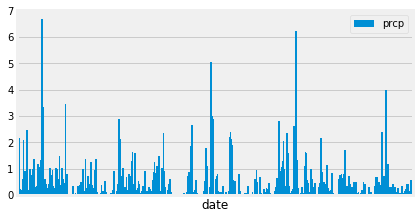

In [12]:

df.plot(kind='bar',width = 10)
plt.tight_layout()
plt.xticks([])
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
stations = []
results = session.query(Measurement.station).all()
for result in results:
    if result not in stations:
        stations.append(result)
len(stations)

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
from sqlalchemy import desc
results = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
results = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
results

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'Temperature Histogram')

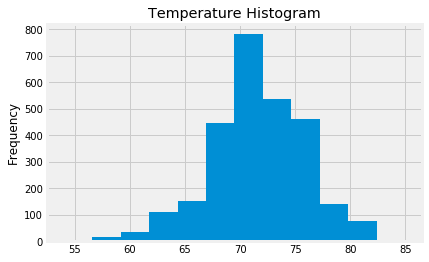

In [68]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station = 'USC00519281'
results = session.query(Measurement.tobs).\
    filter(Measurement.station == station).all()

results = [result[0] for result in results]
plt.hist(results, bins = 12)
plt.ylabel("Frequency")
plt.title("Temperature Histogram")


![precipitation](Images/station-histogram.png)

In [40]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [67]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results = calc_temps('2016-09-01','2016-09-07')
tmin = results[0][0]
tavg = results[0][1]
tmax = results[0][2]
tavg

77.92682926829268

Text(0.5, 1.0, 'Trip Avg Temp')

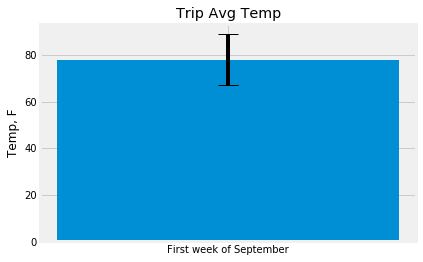

In [72]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = 'First week of September'
error = tmax-tmin
plt.bar(x, tavg, yerr=error, align='center', capsize=10)
plt.ylabel("Temp, F")
plt.title("Trip Avg Temp")


In [78]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

results = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date > '2016-09-01').filter(Measurement.date < '2016-09-07').group_by(Measurement.station).\
    order_by(desc(func.sum(Measurement.prcp))).all()
results

[('USC00516128',
  2.65,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519523',
  0.87,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519281',
  0.41000000000000003,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 0.28, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830',
  0.23,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397', 0.03, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [79]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [107]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals =[]
# Set the start and end date of the trip
start_date = "2016-09-01"
end_date = "2016-09-07"
# Use the start and end date to create a range of dates
import datetime

start = datetime.datetime.strptime(start_date, "%Y-%m-%d")
end = datetime.datetime.strptime(end_date, "%Y-%m-%d")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

dates=[]
for date in date_generated:
    dates.append(date.strftime("%m-%d"))
dates
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_avg = []
tmin = []
tavg = []
tmax = []

for date in dates:
    print(daily_normals(date))
    trip_avg.append(daily_normals(date))
    tmin.append(daily_normals(date)[0][0])
    tavg.append(daily_normals(date)[0][1])
    tmax.append(daily_normals(date)[0][2])

[(69.0, 77.0, 82.0)]
[(67.0, 76.66666666666667, 83.0)]
[(69.0, 76.13725490196079, 83.0)]
[(68.0, 76.27083333333333, 84.0)]
[(66.0, 75.91489361702128, 84.0)]
[(66.0, 74.91111111111111, 81.0)]


In [118]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(list(zip(dates, tmin, tavg, tmax)), 
               columns =['dates','tmin','tavg','tmax']) 
df.set_index('dates')

,tmin,tavg,tmax
dates,,,
09-01,69.0,77.000000,82.0
09-02,67.0,76.666667,83.0
09-03,69.0,76.137255,83.0
09-04,68.0,76.270833,84.0
09-05,66.0,75.914894,84.0
09-06,66.0,74.911111,81.0


Text(0.5, 1.0, 'Trip Avg Temp')

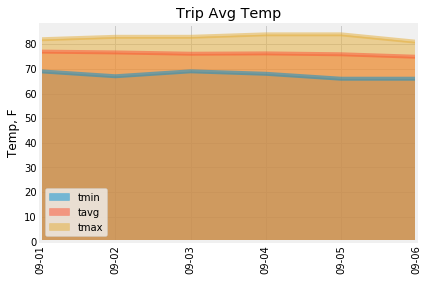

In [125]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked = False)
x_axis = np.arange(len(df))
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, df["dates"], rotation="vertical")
plt.ylabel("Temp, F")
plt.title("Trip Avg Temp")